In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, grid_search
from sklearn.svm import SVC, LinearSVC

import initialize

/home/tosha/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tosha/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_json('./train.json')
test = pd.read_json('./test.json')
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
dict_cuisine = dict()
ind = 0
for cuisine in train.loc[:, 'cuisine']:
    if not (cuisine in dict_cuisine.keys()):
        dict_cuisine[cuisine] = ind
        ind += 1

In [1]:
%%time
new_df = train.loc[initialize.create_subData(1000), :]
print('shape: ', np.shape(new_df))
new_df['ingredients'] = new_df['ingredients'].apply(
    lambda ingredients: initialize.hash_data(ingredients))

new_df['ingredients'] = new_df['ingredients'].apply(lambda x: ' '.join(x))
new_df['cuisine'] = new_df['cuisine'].apply(lambda cuisine: dict_cuisine[cuisine])

vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
new_df_ingr = vect.fit_transform(new_df['ingredients'])

cuisine_train, cuisine_test, y_train, y_test = train_test_split(new_df_ingr, new_df['cuisine'], test_size=0.3)

NameError: name 'train' is not defined

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
%%time
rfc = RandomForestClassifier(n_estimators=80)
rfc.fit(cuisine_train, y_train)

CPU times: user 18.2 s, sys: 45.6 ms, total: 18.2 s
Wall time: 18.3 s


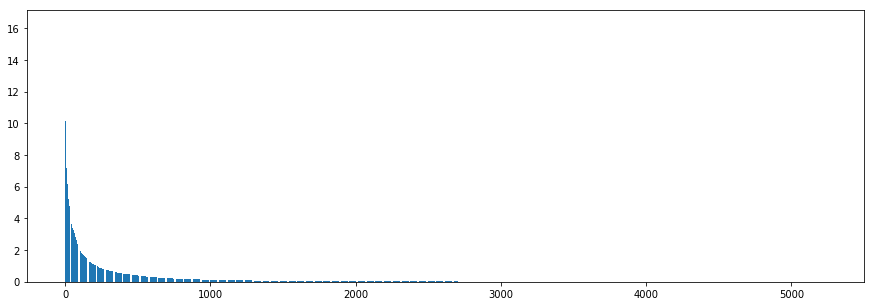

In [7]:
data = rfc.feature_importances_*1000
plt.figure(figsize=(15, 5))
plt.bar(range(len(data)), -np.sort(-data))
plt.show()

In [9]:
np.save('rfc_fi', data)

In [14]:
rf_train = cuisine_train[:, data>0.15]
rf_test = cuisine_test[:, data>0.15]

np.shape(cuisine_train[:, data>0.15])

(12021, 920)

In [9]:
%%time
rfc = RandomForestClassifier(n_estimators=800, max_depth=200)
rfc.fit(rf_train, y_train)
print(metrics.classification_report(y_test, rfc.predict(rf_test)))

             precision    recall  f1-score   support

          0       0.65      0.67      0.66       271
          1       0.46      0.49      0.47       315
          2       0.56      0.60      0.58       225
          3       0.70      0.80      0.75       310
          4       0.79      0.53      0.64       154
          5       0.55      0.60      0.57       284
          6       0.54      0.55      0.54       299
          7       0.70      0.77      0.73       344
          8       0.61      0.70      0.65       279
          9       0.41      0.42      0.41       247
         10       0.69      0.67      0.68       272
         11       0.72      0.55      0.62       253
         12       0.73      0.71      0.72       319
         13       0.74      0.46      0.56       140
         14       0.37      0.51      0.43       283
         15       0.77      0.59      0.67       320
         16       0.57      0.47      0.52       201
         17       0.70      0.74      0.72   

In [17]:
new_df_ingr = new_df_ingr[:, data>0.15]

In [21]:
%%time
parameters_lrc =[
    {
        'C':  [4, 5, 7, 9, 15],
        'penalty': ['l1', 'l2']
    }
]
lrc = LogisticRegression(random_state=1)

grid_cv_lrc = grid_search.GridSearchCV(lrc, parameters_lrc, cv = 5)
grid_cv_lrc.fit(new_df_ingr, new_df['cuisine'])
print(grid_cv_lrc.best_score_, grid_cv_lrc.best_params_)

0.6928317708030047 {'C': 5, 'penalty': 'l2'}
CPU times: user 1min 17s, sys: 95.9 ms, total: 1min 17s
Wall time: 1min 17s


In [26]:
%%time
parameters_svcc =[
    {
        'C': [1, 5, 10, 15, 17],
        'gamma': [1, 3, 5, 10, 15],
        'kernel': ['rbf', 'linear', 'poly']
    }
]
svcc = SVC(random_state=1)

grid_cv_svcc = grid_search.GridSearchCV(svcc, parameters_svcc, cv = 5)
grid_cv_svcc.fit(new_df_ingr, new_df['cuisine'])
print(grid_cv_svcc.best_score_, grid_cv_svcc.best_params_)

KeyboardInterrupt: 